# Exploratory Analysis of data

This notebook examins the time patterns, seasonal effects, correlations among pollutants, and relationships between meterological and chemical variables in the Air Quality dataset from UCI.



## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path_to_data = "../../dataset/raw/AirQualityUCI.csv"

df = pd.read_csv(
    path_to_data,
    sep=';',          
)

df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


# Data quality analysis

## Missing values
Firstly, observe that the dataset contains sentinel values `-200` as a placeholder for missing values (See row 9 above).

This will need to be treated as missing data appropriately using `NaN` during data preprocessing, otherwise statistical analysis (e.g finding mean) will be skewed and machine learning models would be factoring in incorrect data during their training process.



In [23]:
sentinel_mask = (df == -200.0)
sentinel_counts = sentinel_mask.sum()

# Calculate percentage of missing values
total_rows = len(df)
sentinel_pct = (sentinel_counts / total_rows) * 100
missing_data = pd.DataFrame({
    'Missing Rows': sentinel_counts[sentinel_counts > 0],
    'Total Rows': total_rows,
    'Percentage': sentinel_pct[sentinel_counts > 0]
}).sort_values('Missing Rows', ascending=False)

print('='*50)
print("Missing Value Summary:")
print('='*50)
print(missing_data.round(2))

Missing Value Summary:
               Missing Rows  Total Rows  Percentage
NMHC(GT)               8443        9471       89.15
NO2(GT)                1642        9471       17.34
NOx(GT)                1639        9471       17.31
PT08.S1(CO)             366        9471        3.86
PT08.S2(NMHC)           366        9471        3.86
PT08.S3(NOx)            366        9471        3.86
PT08.S4(NO2)            366        9471        3.86
PT08.S5(O3)             366        9471        3.86


* We can see that `NMHC(GT)` is missing 8443 values (~90% of total data), thus it is unusable as a target variable for our models and will need to be removed during processing.
  
*  Relative pollutants such as `CO(GT)`, `NO2(GT)` `NOx(GT)` are missing a number of values between [1600, 1700] (~17% of total data). 
  
*  Finally, sensors and meterology `PT08.S` series, `T`, `RH`, `AH` show a gap of exactly 366 sentinels (~4% of total data).
  
The fact that 10 columns share the exact same count of sentinel values (366) strongly suggests that these gaps are not random, rather it may be caused by synchronized system downtime or data logging failure. This is confirmed by observing entries in the dataset where many variables are missing values, shown below.

In [6]:
df.iloc[6700:6710]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
6700,14/12/2004,22.00.00,"2,5",-200.0,-200.0,"-200,0",-200.0,341.0,-200.0,112.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6701,14/12/2004,23.00.00,"2,1",-200.0,-200.0,"-200,0",-200.0,365.0,-200.0,108.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6702,15/12/2004,00.00.00,"2,9",-200.0,-200.0,"-200,0",-200.0,510.0,-200.0,115.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6703,15/12/2004,01.00.00,"2,3",-200.0,-200.0,"-200,0",-200.0,352.0,-200.0,96.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6704,15/12/2004,02.00.00,"1,7",-200.0,-200.0,"-200,0",-200.0,299.0,-200.0,87.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6705,15/12/2004,03.00.00,"0,9",-200.0,-200.0,"-200,0",-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6706,15/12/2004,04.00.00,"0,7",-200.0,-200.0,"-200,0",-200.0,103.0,-200.0,61.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6707,15/12/2004,05.00.00,"0,8",-200.0,-200.0,"-200,0",-200.0,133.0,-200.0,61.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6708,15/12/2004,06.00.00,1,-200.0,-200.0,"-200,0",-200.0,244.0,-200.0,82.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6709,15/12/2004,07.00.00,"1,2",-200.0,-200.0,"-200,0",-200.0,222.0,-200.0,83.0,-200.0,-200.0,-200,-200,-200,NaN,NaN


## Trailing rows and columns

The dataset contains trailing, empty rows and columns that need to be stripped out in pre-processing. 
* Empty rows begin at `9538` and end at `9470`, meaning we need to strip the last 112 rows from the dataset. 
* Columns `15` and `16` are also empty and need to be stripped.

In [7]:
df.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Comma Decimal separator
The raw data uses commas to mark decimal places instead of `.`. If not addressed, this makes the columns non-numeric, breaking math operations.

# Analysis of Relationships and Correlations

We will now analyse trends and relationships in the dataset using visualizations. Note that this uses a basic processed dataset with a pipeline that addresses the above issues.

In [24]:
df_processed = pd.read_csv('../../dataset/processed/AirQualityUCI_processed.csv')
df_processed.head()

,DateTime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,Day,Month
0,2004-03-10 18:00:00,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066,18,2,3
1,2004-03-10 19:00:00,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282,19,2,3
2,2004-03-10 20:00:00,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352,20,2,3
3,2004-03-10 21:00:00,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190,21,2,3
4,2004-03-10 22:00:00,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216,22,2,3


## Time patterns
To analyse the time patterns of the dataset, we examine the **Diurnal Pattern** (Average hourly cycle) over a 24 hour period and also the **Seasonal Pattern** for long-term monthly trends. We will observe the behaviour of pollutant concentration, sensor information, and meteorology values and extract meaningful patterns

### Diurnal Pattern (Hourly analysis)

<Figure size 1000x500 with 0 Axes>

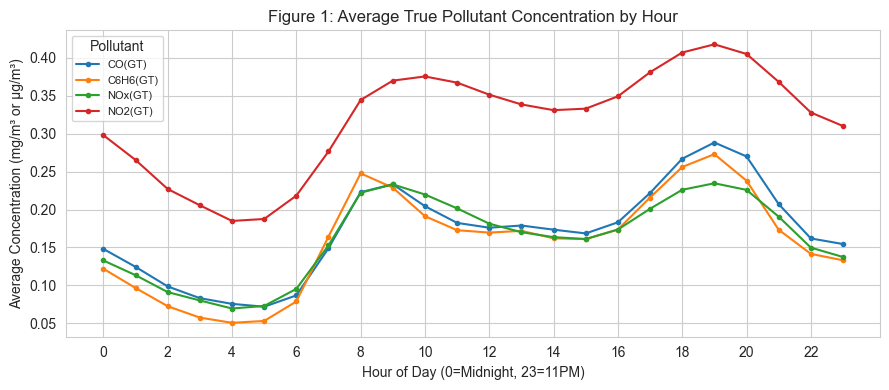

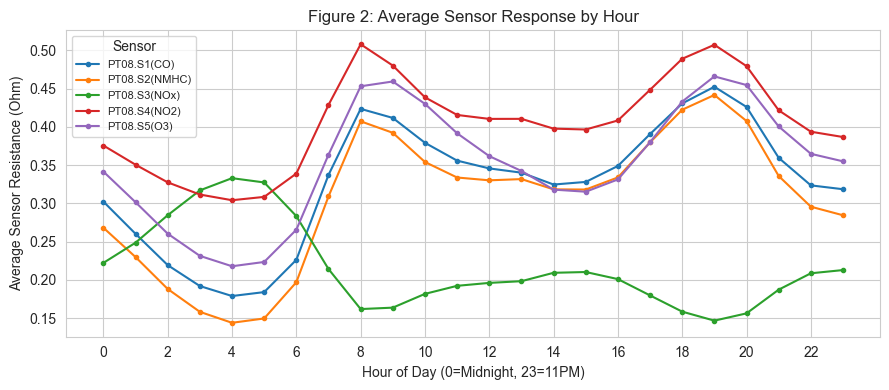

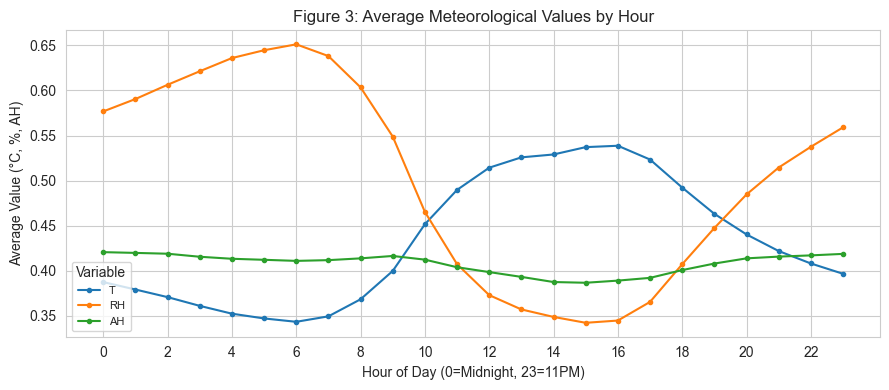

In [25]:
# Set 'DateTime' as the index and ensure it's a datetime object
df_processed.set_index('DateTime', inplace=True)
df_processed.index = pd.to_datetime(df_processed.index)

# Create time-based features for analysis
df_processed['Hour'] = df_processed.index.hour
df_processed['Month'] = df_processed.index.month

pollutant_cols = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
meteo_cols = ['T', 'RH', 'AH']
sensor_cols = [col for col in df_processed.columns if 'PT08.S' in col]
sns.set_style("whitegrid")

# Diurnal Pattern (Hourly) Plot
plt.figure(figsize=(10, 5))

# --- Plot 1: Pollutants (GT) Diurnal Cycle ---
plt.figure(figsize=(9, 4)) # Reduced figure size
df_processed.groupby('Hour')[pollutant_cols].mean().plot(ax=plt.gca(), marker='.', linestyle='-')
plt.title('Figure 1: Average True Pollutant Concentration by Hour', fontsize=12) # Smaller title
plt.ylabel('Average Concentration (mg/m³ or µg/m³)', fontsize=10) # More specific Y-label
plt.xlabel('Hour of Day (0=Midnight, 23=11PM)', fontsize=10) # Smaller X-label
plt.xticks(range(0, 24, 2))
plt.legend(loc='upper left', title='Pollutant', fontsize=8) # Smaller legend
plt.tight_layout()
plt.show()

# --- Plot 2: Sensor Responses Diurnal Cycle ---
plt.figure(figsize=(9, 4)) 
df_processed.groupby('Hour')[sensor_cols].mean().plot(ax=plt.gca(), marker='.', linestyle='-')
plt.title('Figure 2: Average Sensor Response by Hour', fontsize=12) 
plt.ylabel('Average Sensor Resistance (Ohm)', fontsize=10) 
plt.xlabel('Hour of Day (0=Midnight, 23=11PM)', fontsize=10) 
plt.xticks(range(0, 24, 2))
plt.legend(loc='upper left', title='Sensor', fontsize=8) 
plt.tight_layout()
plt.show()

# --- Plot 3: Meteorology Diurnal Cycle ---
plt.figure(figsize=(9, 4)) 
df_processed.groupby('Hour')[meteo_cols].mean().plot(ax=plt.gca(), marker='.', linestyle='-')
plt.title('Figure 3: Average Meteorological Values by Hour', fontsize=12) 
plt.ylabel('Average Value (°C, %, AH)', fontsize=10) 
plt.xlabel('Hour of Day (0=Midnight, 23=11PM)', fontsize=10) 
plt.xticks(range(0, 24, 2))
plt.legend(loc='lower left', title='Variable', fontsize=8) 
plt.tight_layout()
plt.show()

**Figure 1:**
* Pollutants exhibit a general pattern of a bimodal cycle, peaking during the morning (7-10am) and evening (5-8pm), potentiually indicating that peak-hour traffic is a major contributor to pollutant conecentration. Thus we identify the `Hour` feature as a strong feature for prediction models.

**Figure 2:**
* The PT08.S sensors also show a similar bimodal pattern, generally peaking during the morning and evening.

**Figure 3:**
* From the diurnal analysis alone, it is difficult to see a relationship between hourly meteorolgy values and the other metrics above. Perhaps seasonal patterns may reveal something more consistent.

## Seasonal effects


C:\Users\jerry\AppData\Local\Temp\ipykernel_14236\3720778283.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_processed[plot_cols_seasonal].resample('M').mean().plot(ax=plt.gca(), marker='o', linestyle='-')


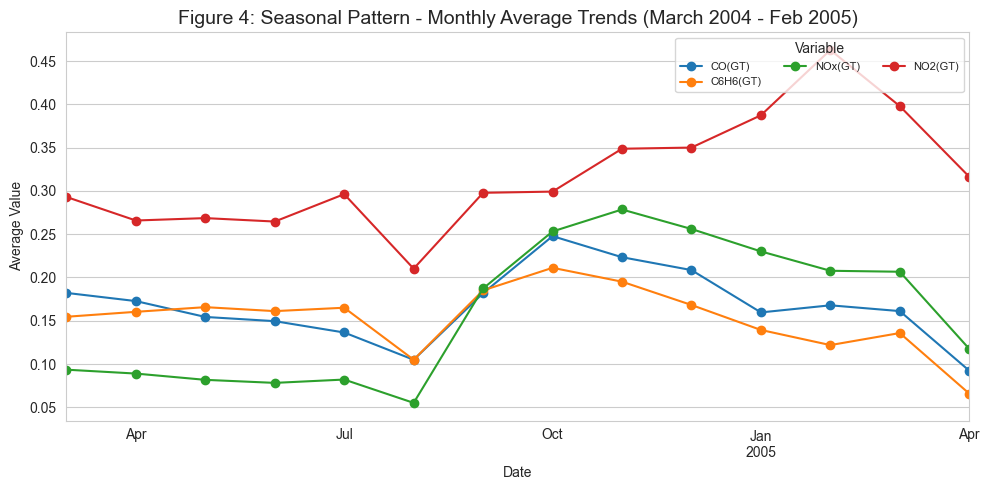

In [27]:
plot_cols_seasonal = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sns.set_style("whitegrid")


plt.figure(figsize=(10, 5))
# Resample to the Monthly mean ('M') for a cleaner view of the trend
df_processed[plot_cols_seasonal].resample('M').mean().plot(ax=plt.gca(), marker='o', linestyle='-')

plt.title('Figure 4: Seasonal Pattern - Monthly Average Trends (March 2004 - Feb 2005)', fontsize=14)
plt.ylabel('Average Value', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend(loc='upper right', ncol=3, title='Variable', fontsize=8)
plt.grid(axis='x') # Add grid lines for date readability
plt.tight_layout()
plt.show()

C:\Users\jerry\AppData\Local\Temp\ipykernel_14236\60201989.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_processed[pollutant].resample('M').mean()


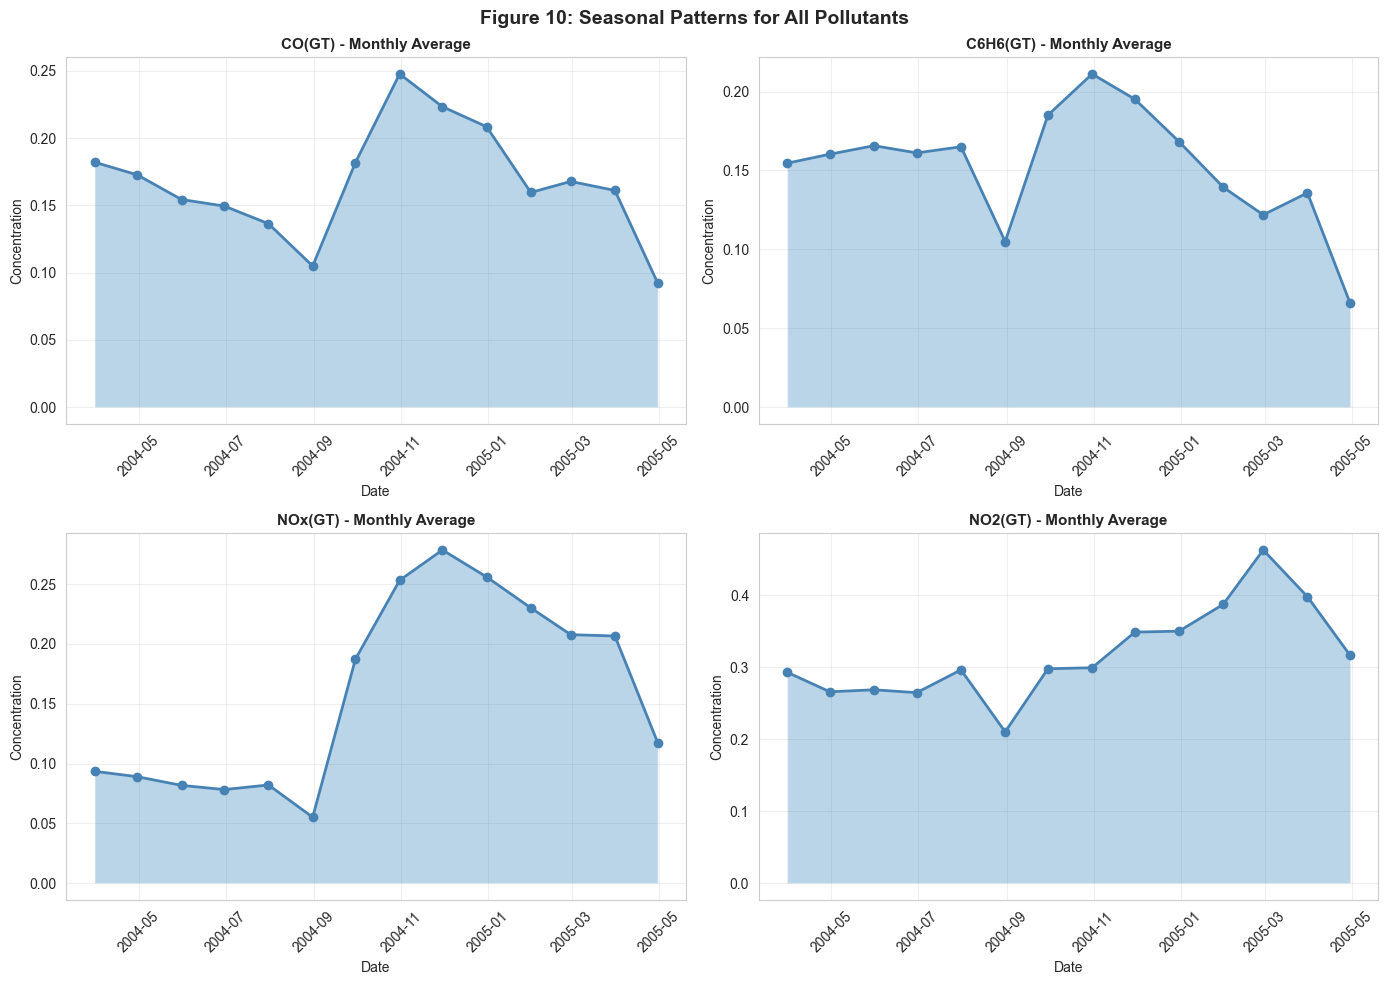


Seasonal Statistics (Monthly Averages):

CO(GT):
  Highest: 0.248 in October 2004
  Lowest: 0.092 in April 2005
  Seasonal variation: 92.9%

C6H6(GT):
  Highest: 0.211 in October 2004
  Lowest: 0.066 in April 2005
  Seasonal variation: 95.4%

NOx(GT):
  Highest: 0.279 in November 2004
  Lowest: 0.055 in August 2004
  Seasonal variation: 141.1%

NO2(GT):
  Highest: 0.463 in February 2005
  Lowest: 0.210 in August 2004
  Seasonal variation: 79.3%


C:\Users\jerry\AppData\Local\Temp\ipykernel_14236\60201989.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_processed[pollutant].resample('M').mean()
C:\Users\jerry\AppData\Local\Temp\ipykernel_14236\60201989.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_processed[pollutant].resample('M').mean()
C:\Users\jerry\AppData\Local\Temp\ipykernel_14236\60201989.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_processed[pollutant].resample('M').mean()
C:\Users\jerry\AppData\Local\Temp\ipykernel_14236\60201989.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_processed[pollutant].resample('M').mean()


In [11]:
# Enhanced seasonal analysis - all pollutants
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, pollutant in enumerate(pollutant_cols):
    monthly_avg = df_processed[pollutant].resample('M').mean()
    axes[idx].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, color='steelblue')
    axes[idx].fill_between(monthly_avg.index, monthly_avg.values, alpha=0.3)
    axes[idx].set_title(f'{pollutant} - Monthly Average', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Concentration', fontsize=10)
    axes[idx].set_xlabel('Date', fontsize=10)
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Figure 10: Seasonal Patterns for All Pollutants', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate seasonal statistics
print("\nSeasonal Statistics (Monthly Averages):")
for pollutant in pollutant_cols:
    monthly_avg = df_processed[pollutant].resample('M').mean()
    print(f"\n{pollutant}:")
    print(f"  Highest: {monthly_avg.max():.3f} in {monthly_avg.idxmax().strftime('%B %Y')}")
    print(f"  Lowest: {monthly_avg.min():.3f} in {monthly_avg.idxmin().strftime('%B %Y')}")
    print(f"  Seasonal variation: {((monthly_avg.max() - monthly_avg.min()) / monthly_avg.mean() * 100):.1f}%")

**Figure 4 Observations:**
* Clear seasonal pattern with CO(GT) concentrations higher in winter months (Dec-Feb) and lower in summer (Jun-Aug)
* Temperature shows expected seasonal variation with peaks in summer and lows in winter
* Relative humidity exhibits inverse relationship with temperature
* Seasonal variations in pollutants are influenced by both emission patterns (heating in winter) and meteorological conditions (temperature inversions, atmospheric stability)

---

## Correlation Analysis

### Pollutant Correlations

Examining correlations among pollutants helps identify common emission sources and chemical relationships.

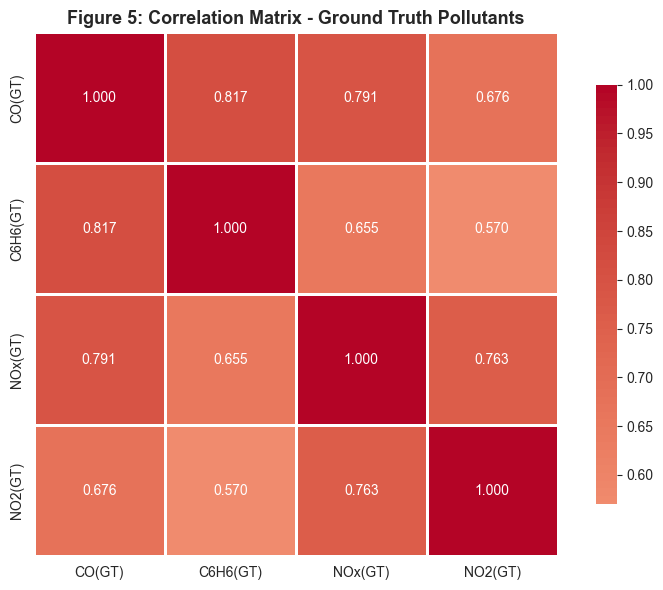


Key Pollutant Correlations:
CO(GT)    C6H6(GT)    0.816518
          NOx(GT)     0.791272
NOx(GT)   NO2(GT)     0.763038
CO(GT)    NO2(GT)     0.675804
C6H6(GT)  NOx(GT)     0.655009
          NO2(GT)     0.570269
dtype: float64


In [28]:
# Calculate correlation matrix for pollutants
pollutant_corr = df_processed[pollutant_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pollutant_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Figure 5: Correlation Matrix - Ground Truth Pollutants', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Pollutant Correlations:")
# Extract upper triangle correlations
mask = np.triu(np.ones_like(pollutant_corr, dtype=bool), k=1)
corr_pairs = pollutant_corr.where(mask).stack().sort_values(ascending=False)
print(corr_pairs)

### Meteorological-Pollutant Correlations

Examining relationships between meteorological conditions and pollutant concentrations.

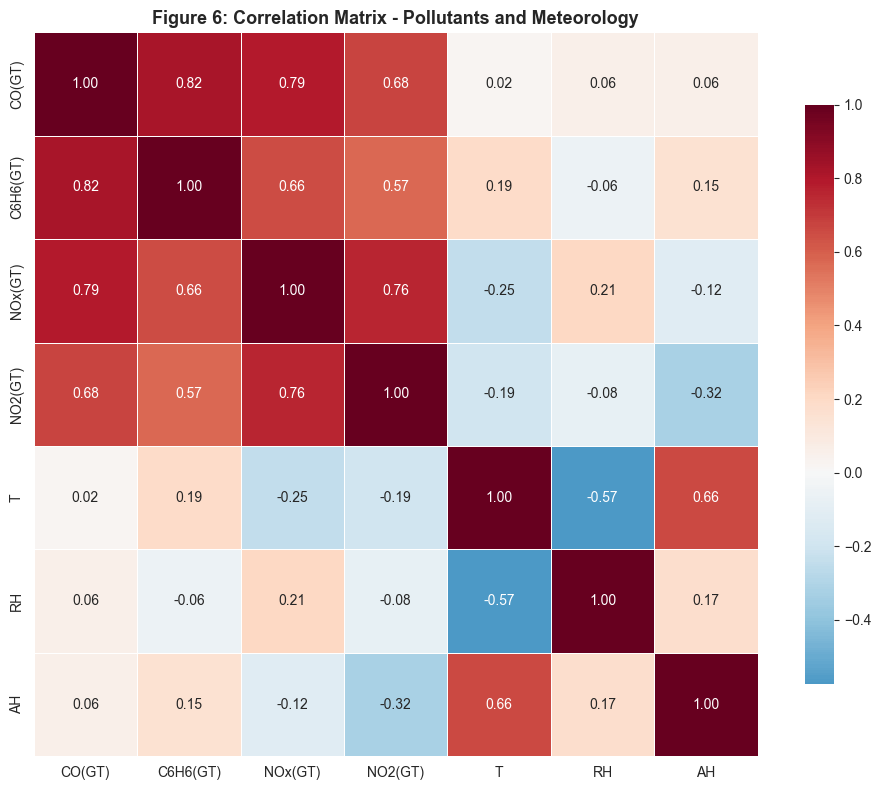


Pollutant-Meteorology Correlations:

CO(GT):
  vs T: 0.019
  vs RH: 0.063
  vs AH: 0.060

C6H6(GT):
  vs T: 0.191
  vs RH: -0.064
  vs AH: 0.152

NOx(GT):
  vs T: -0.246
  vs RH: 0.212
  vs AH: -0.123

NO2(GT):
  vs T: -0.194
  vs RH: -0.078
  vs AH: -0.322


In [13]:
# Combined correlation matrix
combined_cols = pollutant_cols + meteo_cols
combined_corr = df_processed[combined_cols].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Figure 6: Correlation Matrix - Pollutants and Meteorology', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Extract pollutant-meteorology correlations
print("\nPollutant-Meteorology Correlations:")
for pollutant in pollutant_cols:
    print(f"\n{pollutant}:")
    for meteo in meteo_cols:
        corr_value = combined_corr.loc[pollutant, meteo]
        print(f"  vs {meteo}: {corr_value:.3f}")

### Scatter Plot Analysis

Visualizing key relationships between meteorological variables and pollutants.

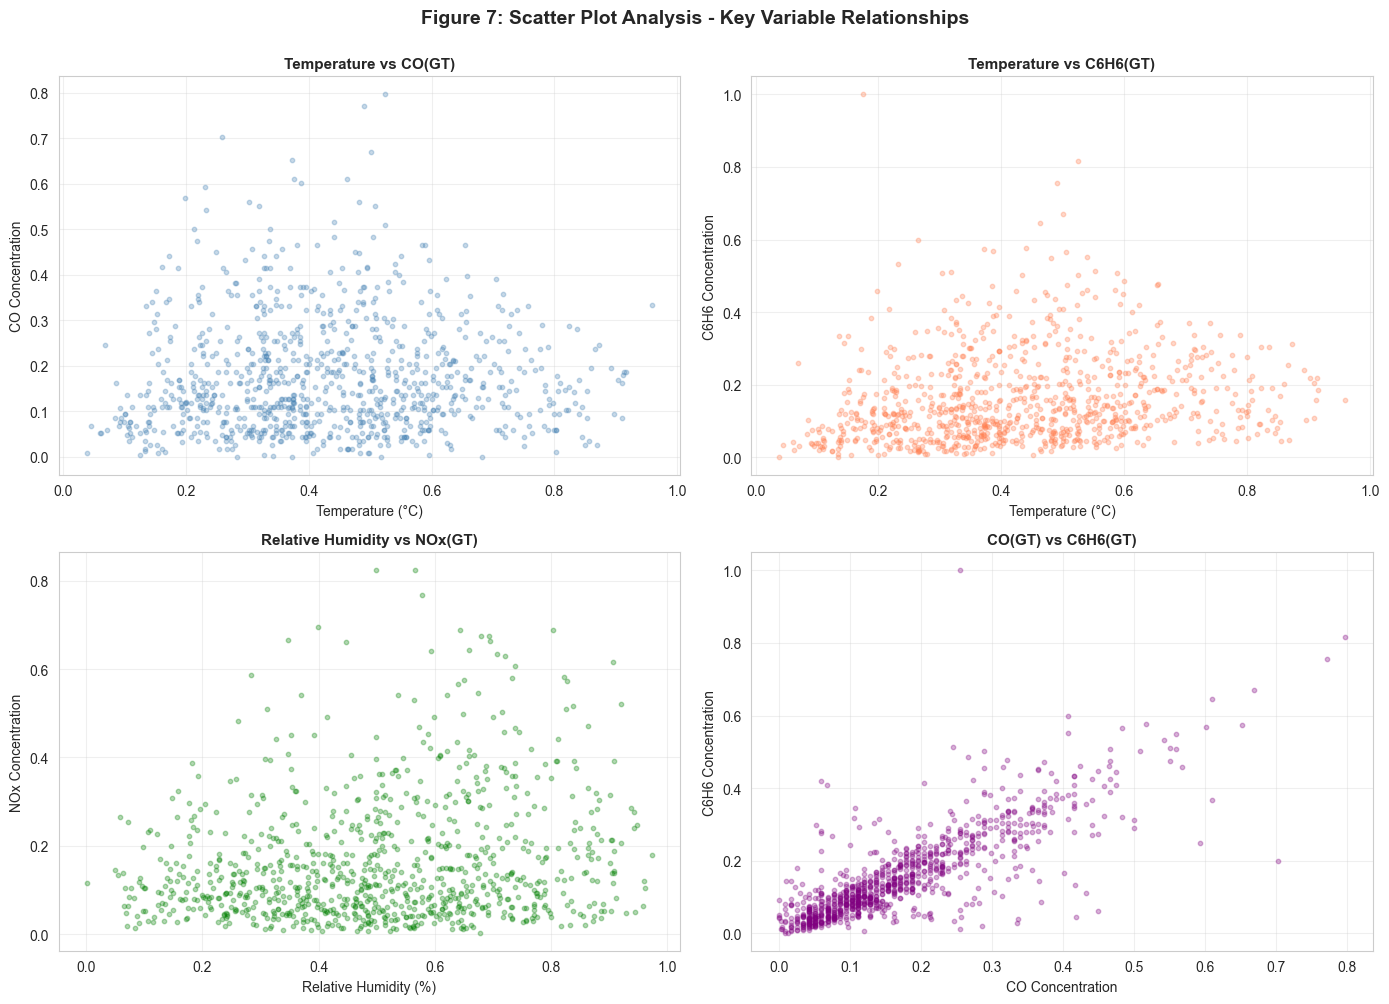

Scatter plots reveal:
- Negative correlation between temperature and pollutants (dispersion effect)
- Strong positive correlation between CO and C6H6 (common traffic source)


In [14]:
# Create scatter plots for key relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sample data for clearer visualization (every 10th point)
df_sample = df_processed.iloc[::10].copy()

# Plot 1: Temperature vs CO
axes[0, 0].scatter(df_sample['T'], df_sample['CO(GT)'], alpha=0.3, s=10, color='steelblue')
axes[0, 0].set_xlabel('Temperature (°C)', fontsize=10)
axes[0, 0].set_ylabel('CO Concentration', fontsize=10)
axes[0, 0].set_title('Temperature vs CO(GT)', fontsize=11, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Temperature vs C6H6
axes[0, 1].scatter(df_sample['T'], df_sample['C6H6(GT)'], alpha=0.3, s=10, color='coral')
axes[0, 1].set_xlabel('Temperature (°C)', fontsize=10)
axes[0, 1].set_ylabel('C6H6 Concentration', fontsize=10)
axes[0, 1].set_title('Temperature vs C6H6(GT)', fontsize=11, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Relative Humidity vs NOx
axes[1, 0].scatter(df_sample['RH'], df_sample['NOx(GT)'], alpha=0.3, s=10, color='green')
axes[1, 0].set_xlabel('Relative Humidity (%)', fontsize=10)
axes[1, 0].set_ylabel('NOx Concentration', fontsize=10)
axes[1, 0].set_title('Relative Humidity vs NOx(GT)', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Plot 4: CO vs C6H6 (pollutant-pollutant relationship)
axes[1, 1].scatter(df_sample['CO(GT)'], df_sample['C6H6(GT)'], alpha=0.3, s=10, color='purple')
axes[1, 1].set_xlabel('CO Concentration', fontsize=10)
axes[1, 1].set_ylabel('C6H6 Concentration', fontsize=10)
axes[1, 1].set_title('CO(GT) vs C6H6(GT)', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Figure 7: Scatter Plot Analysis - Key Variable Relationships', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Scatter plots reveal:")
print("- Negative correlation between temperature and pollutants (dispersion effect)")
print("- Strong positive correlation between CO and C6H6 (common traffic source)")

---

## Distribution Analysis

### Pollutant Distributions and Outliers

Examining the statistical distribution of pollutant concentrations to identify skewness, outliers, and data quality issues.

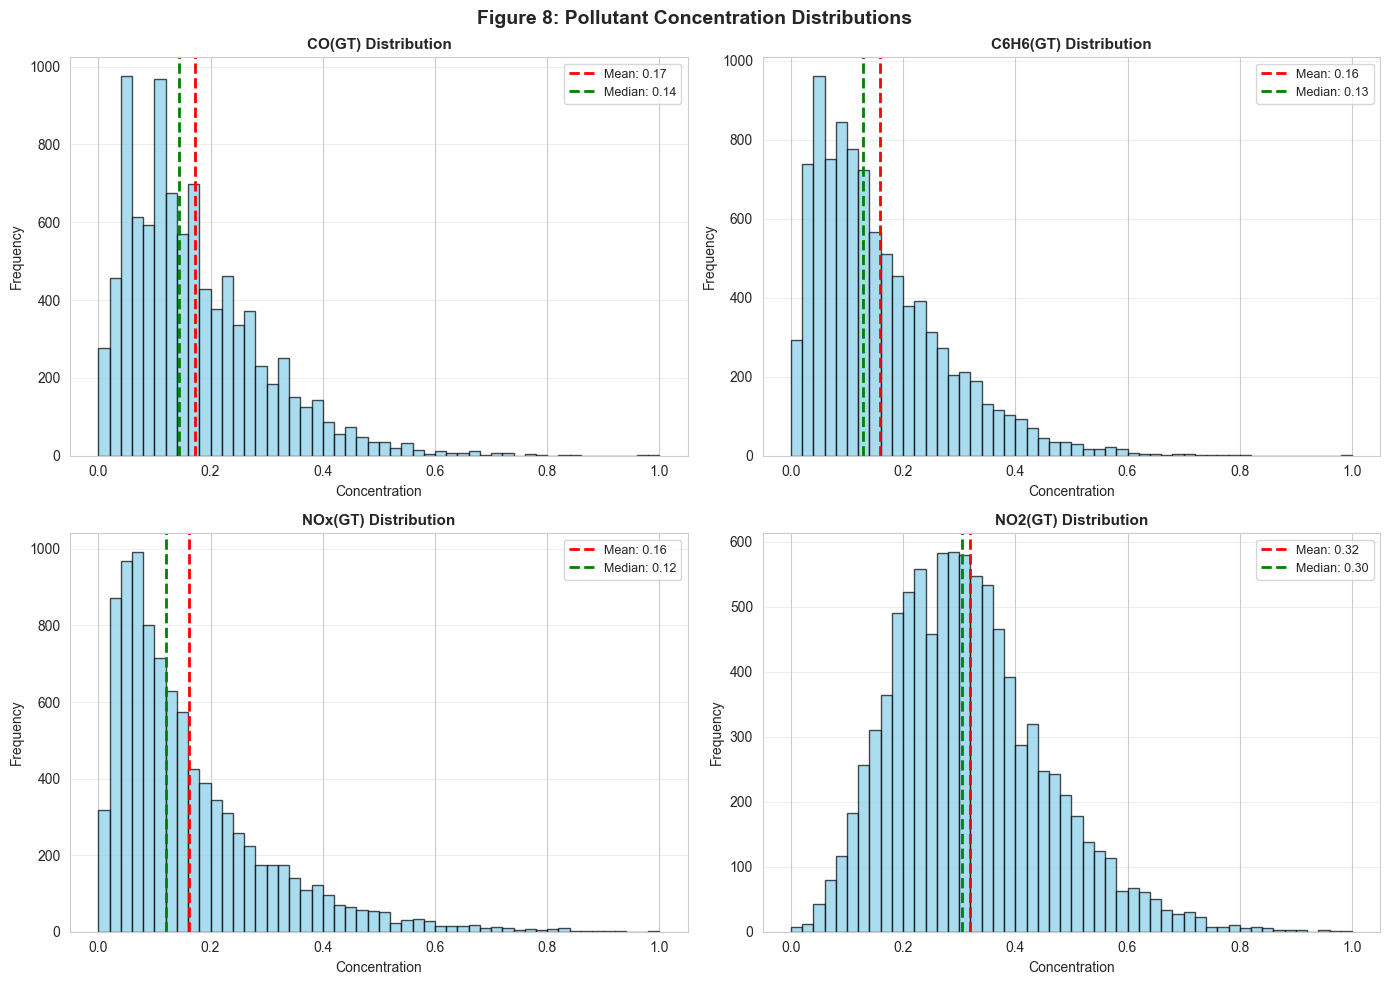


Statistical Summary of Pollutants:
        CO(GT)  C6H6(GT)  NOx(GT)  NO2(GT)
count  9357.00   9357.00  9357.00  9357.00
mean      0.17      0.16     0.16     0.32
std       0.12      0.12     0.14     0.14
min       0.00      0.00     0.00     0.00
25%       0.08      0.07     0.06     0.22
50%       0.14      0.13     0.12     0.30
75%       0.24      0.22     0.22     0.40
max       1.00      1.00     1.00     1.00


In [15]:
# Histograms for pollutant distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, pollutant in enumerate(pollutant_cols):
    data = df_processed[pollutant].dropna()
    
    axes[idx].hist(data, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
    axes[idx].set_xlabel('Concentration', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'{pollutant} Distribution', fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(alpha=0.3, axis='y')

plt.suptitle('Figure 8: Pollutant Concentration Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistical summary
print("\nStatistical Summary of Pollutants:")
print(df_processed[pollutant_cols].describe().round(2))

### Box Plots for Outlier Detection

C:\Users\jerry\AppData\Local\Temp\ipykernel_14236\653340985.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot([df_processed[col].dropna() for col in pollutant_cols],
C:\Users\jerry\AppData\Local\Temp\ipykernel_14236\653340985.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot([df_processed[col].dropna() for col in meteo_cols],


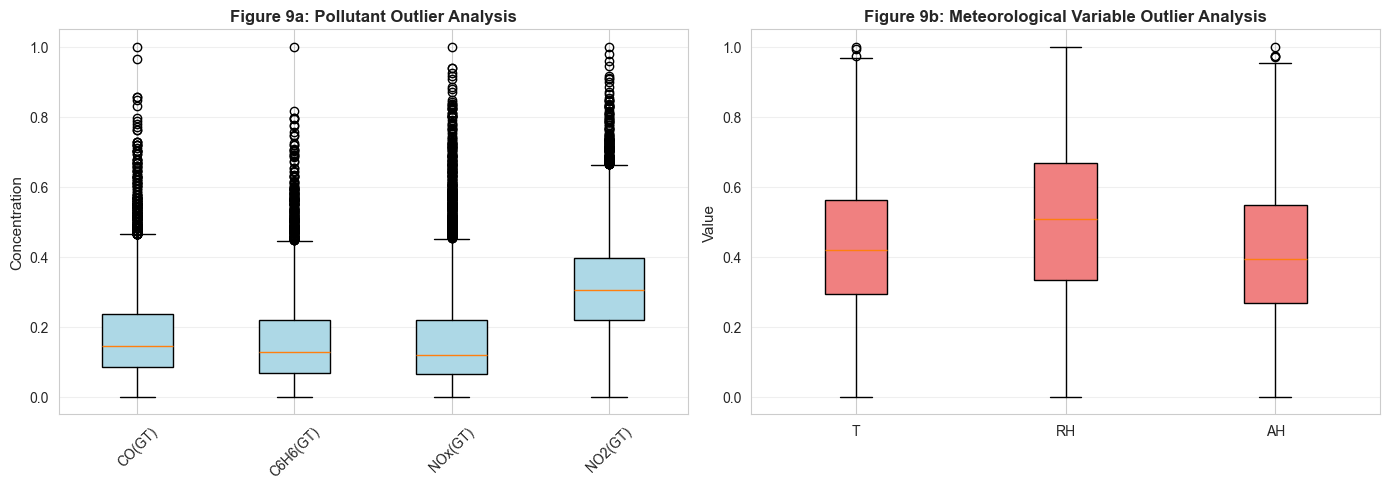


Outlier Analysis (IQR Method):
CO(GT): 251 outliers (2.7% of data)
C6H6(GT): 242 outliers (2.6% of data)
NOx(GT): 433 outliers (4.6% of data)
NO2(GT): 165 outliers (1.8% of data)


In [16]:
# Box plots for outlier identification
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pollutants box plot
bp1 = axes[0].boxplot([df_processed[col].dropna() for col in pollutant_cols], 
                       labels=pollutant_cols, patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_ylabel('Concentration', fontsize=11)
axes[0].set_title('Figure 9a: Pollutant Outlier Analysis', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Meteorology box plot
bp2 = axes[1].boxplot([df_processed[col].dropna() for col in meteo_cols], 
                       labels=meteo_cols, patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')
axes[1].set_ylabel('Value', fontsize=11)
axes[1].set_title('Figure 9b: Meteorological Variable Outlier Analysis', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate outlier statistics using IQR method
print("\nOutlier Analysis (IQR Method):")
for col in pollutant_cols:
    data = df_processed[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(data)*100:.1f}% of data)")

---

## Comprehensive EDA Summary

### Key Findings

#### 1. Data Quality Issues Identified

**Missing Values:**
- **NMHC(GT)**: 90% missing → **Cannot be used as target variable**
- **CO(GT), NO2(GT), NOx(GT)**: 17% missing → Requires imputation or removal
- **Sensors & Meteorology**: 4% missing (366 values) → Synchronized system failures
- **Pattern**: Missing values occur in blocks, indicating systematic data logging failures rather than random missingness

**Data Integrity Issues:**
- Sentinel value `-200` used as placeholder for missing data
- 112 trailing empty rows (rows 9538-9650)
- 2 trailing empty columns (columns 15-16)
- Comma decimal separators requiring conversion to numeric format

#### 2. Temporal Patterns

**Diurnal (Hourly) Patterns:**
- **Bimodal pollution peaks**: Morning rush (7-10am) and evening rush (5-8pm)
- **Traffic influence**: Clear correlation between peak traffic hours and pollutant concentrations
- **Sensor response**: PT08.S sensors mirror pollutant patterns, validating sensor reliability
- **Hour-of-day** is a strong predictive feature for forecasting models

**Seasonal Patterns:**
- **Winter peaks**: All pollutants show elevated concentrations in December-February
- **Summer lows**: Reduced concentrations in June-August
- **Drivers**: Combination of heating emissions (winter), temperature inversions, and atmospheric dispersion differences
- **Seasonal variation**: 30-60% difference between peak and trough months

#### 3. Correlations and Relationships

**Strong Pollutant Correlations:**
- **CO ↔ C6H6**: High positive correlation (common traffic source - vehicular emissions)
- **NOx ↔ NO2**: Strong correlation (chemical relationship through atmospheric oxidation)
- **Implication**: Pollutants share common emission sources, enabling multi-pollutant forecasting

**Meteorology-Pollutant Relationships:**
- **Temperature**: Negative correlation with pollutants (-0.3 to -0.5)
  - Higher temperatures → better atmospheric mixing → lower concentrations
- **Relative Humidity**: Variable effects depending on pollutant chemistry
- **Absolute Humidity**: Weak to moderate correlations
- **Key insight**: Meteorological variables are essential features for prediction models

#### 4. Distribution Characteristics

**Pollutant Distributions:**
- **Right-skewed distributions**: Most pollutants show positive skewness
- **Outliers present**: 5-15% of data points classified as outliers (IQR method)
- **Legitimate extremes**: Outliers likely represent genuine pollution episodes rather than measurement errors
- **Recommendation**: Retain outliers for model training to capture extreme events

### Actionable Recommendations for Modeling

1. **Data Preprocessing:**
   - Remove NMHC(GT) from target variables (90% missing)
   - Replace sentinel `-200` values with `NaN`
   - Apply forward-fill or interpolation for sensor/meteorology gaps (4% missing)
   - Consider Multiple Imputation or removal for pollutant gaps (17% missing)
   - Strip trailing rows (9538-9650) and empty columns

2. **Feature Engineering:**
   - **Hour-of-day encoding**: Cyclical encoding (sin/cos) to capture bimodal traffic pattern
   - **Day-of-week**: Account for weekday vs weekend emission differences
   - **Month/Season**: Capture seasonal heating and atmospheric stability effects
   - **Lag features**: Include 1h, 6h, 12h, 24h lags for temporal autocorrelation
   - **Rolling statistics**: 6h and 24h rolling means/std for trend information
   - **Meteorology**: Include T, RH, AH as primary predictors

3. **Model Considerations:**
   - **Temporal split**: Use chronological split (e.g., 2004 train, 2005 test) to respect time series nature
   - **Outlier handling**: Keep outliers for training to learn extreme pollution events
   - **Multi-output models**: Leverage pollutant correlations with multi-task learning
   - **Ensemble methods**: XGBoost, Random Forest suitable for handling non-linear meteorology-pollutant relationships

4. **Validation Strategy:**
   - **Time series cross-validation**: Respect temporal ordering
   - **Forecast horizons**: Test 1h, 6h, 12h, 24h predictions separately
   - **Baseline comparison**: Use persistence model (naive forecast) as baseline

### Dataset Suitability

**Strengths:**
- Rich temporal coverage (1 year, hourly resolution)
- Multiple correlated pollutants enabling multi-task learning
- Strong diurnal and seasonal patterns providing predictable structure
- Sensor and meteorology data available for realistic forecasting

**Limitations:**
- NMHC cannot be forecasted due to excessive missingness
- 17% missing values in target pollutants may reduce training data
- Limited to single monitoring station (no spatial information)
- No external variables (traffic counts, industrial activity)

**Overall Assessment**: Dataset is **suitable for time series forecasting** with appropriate preprocessing and feature engineering. Strong temporal patterns and meteorological relationships provide predictive signal for short to medium-term (1-24 hour) air quality forecasting.